# summary data 
- record 04015 ([1:])
- record 04043 ([1:16])
- record 04048 ([1:6])
- record 04126 ([1:])
- record 04746 (tidak di proses, karena kebanyakan data N)
- record 04908 ([1:])
- record 04936 ([4:])
- record 05091 ([1:])
- record 05121 ([1:])
- record 05261 ([1:18])
- record 06426 ([1:])
- record 06453 ([1:])
- record 06995 ([1:])
- record 07162 (tidak di proses, isinya hanya AF)
- record 07859 (tidak di proses, isinya hanya AF)
- record 07879 (tidak di proses, karena kebanyakan data N)
- record 07910 ([1:10])
- record 08215 ([1:])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

In [2]:
record = "08215"

In [3]:
dataset_dir = "dataset/AFDB record_%s/" % record

csv_filenames = []
for filename in os.listdir(dataset_dir) :
    if filename.find(".csv") > -1:
        csv_filenames.append(filename)
        
csv_filenames

['DATA.csv']

- Read Annotation file

In [4]:
file = open(dataset_dir + 'annotation.txt',"r") 
annotations = file.readlines()
file.close()

In [5]:
annotations

['      Time     Sample #  Type  Sub Chan  Num\tAux\n',
 '[16:00:00.632]      158     +    0    0    0\t(N\n',
 '[17:58:18.832]  1774708     +    0    0    0\t(AFIB\n',
 '[19:33:37.740]  3204435     +    0    0    0\t(AFL\n',
 '[19:34:27.980]  3216995     +    0    0    0\t(AFIB\n']

In [6]:
label_idx = []
for item in annotations[1:] :
    item_split = item.split()
    label_idx.append([item_split[0].replace("[", "").replace("]", ""), item_split[-1].replace("(", "")])

In [7]:
label_idx

[['16:00:00.632', 'N'],
 ['17:58:18.832', 'AFIB'],
 ['19:33:37.740', 'AFL'],
 ['19:34:27.980', 'AFIB']]

- Read & formatting ECG data

In [8]:
def read_csv_to_df(filename, folder, sep=","):
    df = pd.read_csv(folder + filename, sep=sep)
    print("[INFO] finish read file - %s" % filename)
    
    #df = df.drop(0) 
    df.columns = ['Time', 'ECG']

    # reduce sampling rate from 250Hz to 125Hz     
    df = df.iloc[::2]
    
    #df['ECG'] = df['ECG'].str.replace(';', '')
    df['ECG'] = pd.to_numeric(df['ECG'])
    
    # peak reduction
    df[df['ECG'] > 2] = 10
    df[df['ECG'] < -2] = -5
    
    print("[INFO] finish data cleansing - %s" % filename)

    df["Time"] = df['Time'].str.replace("[", "")
    df["Time"] = df['Time'].str.replace("]", "")
    df["Time"] = df['Time'].str.replace("'", "")

    df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
    print("[INFO] finish time cleansing -  %s" % filename)
    
    df.set_index("Time", inplace=True)
    return df

- concate datafarame

In [9]:
list_df_ecg = []
for name in csv_filenames:
    df = read_csv_to_df(name, dataset_dir)
    list_df_ecg.append(df)
    
df_ecg = pd.concat(list_df_ecg)

[INFO] finish read file - DATA.csv
[INFO] finish data cleansing - DATA.csv
[INFO] finish time cleansing -  DATA.csv


In [10]:
df_ecg.tail()

,ECG
Time,
2020-12-30 19:34:59.960,0.045
2020-12-30 19:34:59.968,0.090
2020-12-30 19:34:59.976,0.110
2020-12-30 19:34:59.984,0.120
2020-12-30 19:34:59.992,0.150


- plot signal 

In [11]:
def plot_signal(data, fs, label="ECG sample raw data"):
    data = data.values[:,0]
    plt.figure(figsize=(20, 5))
    plt.ylabel("Amplitude")

    # Calculate time values in seconds
    times = np.arange(data.shape[0], dtype='float') / fs

    plt.plot(times, data)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    plt.ylim([-2.1, 2.1])
    plt.title(label)
    plt.grid(True)
    plt.show()

In [12]:
fs = 125 #hz

16:00:00 16:00:16


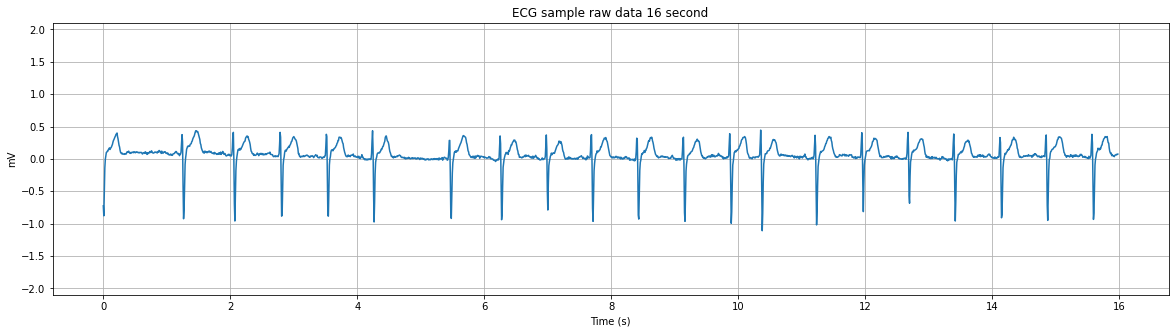

In [13]:
start = df_ecg.index[0].time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=16)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "ECG sample raw data 16 second")

16:00:16 16:00:32


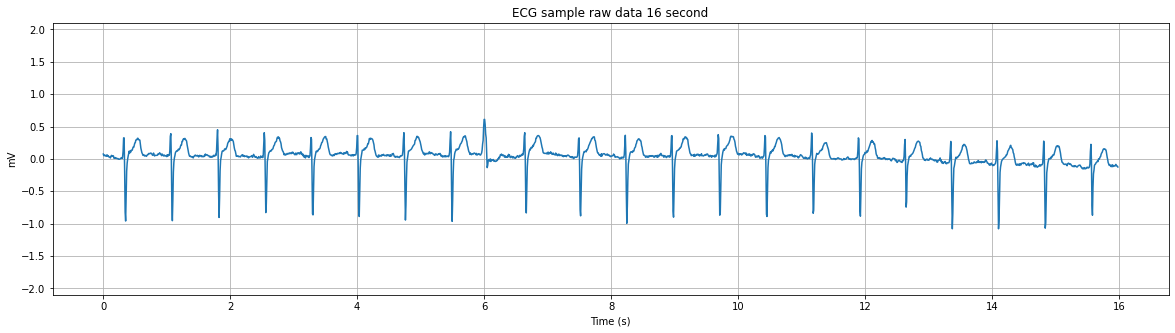

In [14]:
start = (df_ecg.index[0] + datetime.timedelta(seconds=16)).time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=32)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "ECG sample raw data 16 second")

- Split Normal (N) and AFIB data

In [15]:
label_idx

[['16:00:00.632', 'N'],
 ['17:58:18.832', 'AFIB'],
 ['19:33:37.740', 'AFL'],
 ['19:34:27.980', 'AFIB']]

In [16]:
N_range = []
AFIB_range = []

for i in range(len(label_idx) - 1):
    tm_str = label_idx[i][0]
    next_tm_str = label_idx[i + 1][0]
    tm = pd.to_datetime(tm_str)
    next_tm = pd.to_datetime(next_tm_str)
    
    if label_idx[i][1] == 'N' :
        N_range.append([tm, next_tm])
    elif label_idx[i][1] == 'AFIB' :
        AFIB_range.append([tm, next_tm])

In [17]:
N = []
for nr in N_range :
    result = df_ecg.between_time(nr[0].time(), nr[1].time())
    N.append(result)

In [18]:
AFIB = []
for ar in AFIB_range :
    result = df_ecg.between_time(ar[0].time(), ar[1].time())
    AFIB.append(result)

- split each N & AFIB dataframe to 16s sequence and apply Baseline Removal 

In [19]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [20]:
def plot_16s_sample(data, label="Plot 16 s sample", y_label = 'mV'):
    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

In [21]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [22]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [23]:
time_interval_N = []
for N_item in N:
    if len(N_item) > 0:
        intr = [time_result for time_result in perdelta(N_item.index[0], N_item.index[-1], timedelta(seconds=16))]
        time_interval_N.append(intr)

In [24]:
time_interval_AFIB = []
for AFIB_item in AFIB:
    if len(AFIB_item) > 0:
        intr = [time_result for time_result in perdelta(AFIB_item.index[0], AFIB_item.index[-1], timedelta(seconds=16))]
        time_interval_AFIB.append(intr)

In [25]:
ECG_ALS = []
ECG_ALS_label = []

for time_interval in time_interval_N :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        X_val = X.values[:,0]
        if len(X_val) > 0 :
            ALS = X_val - baseline_als(X_val)
            ECG_ALS.append(np.array(ALS))
            ECG_ALS_label.append('N')
    
for time_interval in time_interval_AFIB :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        X_val = X.values[:,0]
        if len(X_val) > 0 :
            ALS = X_val - baseline_als(X_val)
            ECG_ALS.append(np.array(ALS))
            ECG_ALS_label.append('AF')

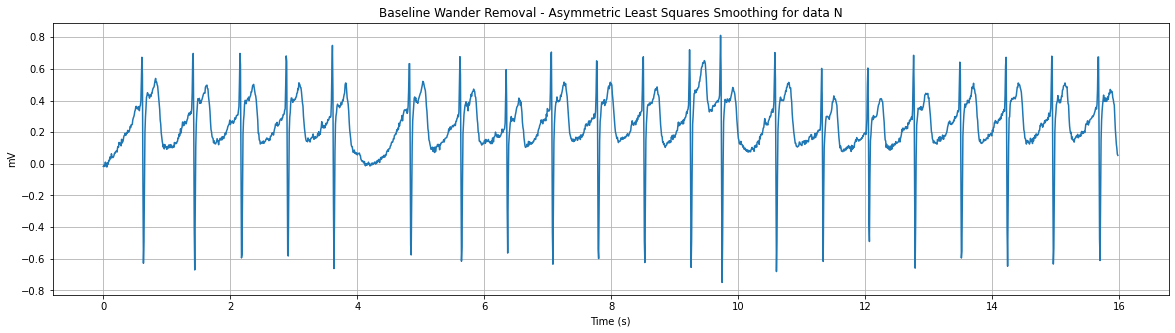

In [26]:
idx = 0
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

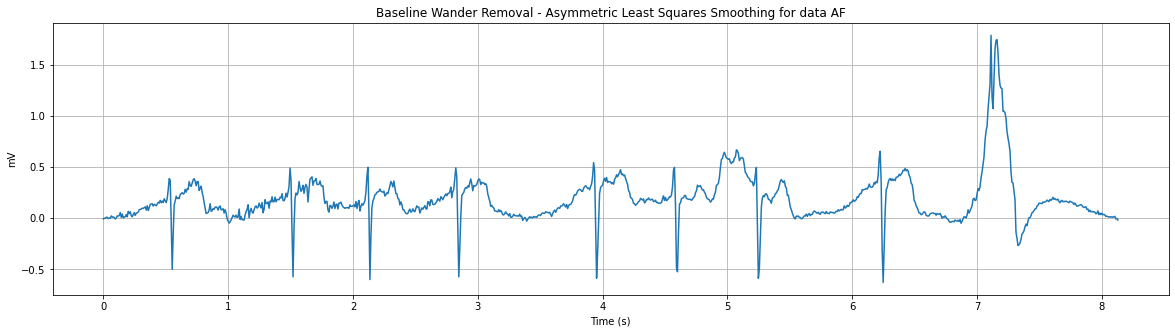

In [27]:
idx = -3
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

- Signal normalization from -1 to 1

In [28]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

In [29]:
#scaler = MinMaxScaler(feature_range=(-1, 1)) # scale to -1 to 1
scaler = MaxAbsScaler()
ECG_ALS_Norm = []

for als in ECG_ALS :
    als = np.expand_dims(als, 1)
    scaler = scaler.fit(als)
    
    als_norm = scaler.transform(als) 
    ECG_ALS_Norm.append(als_norm)

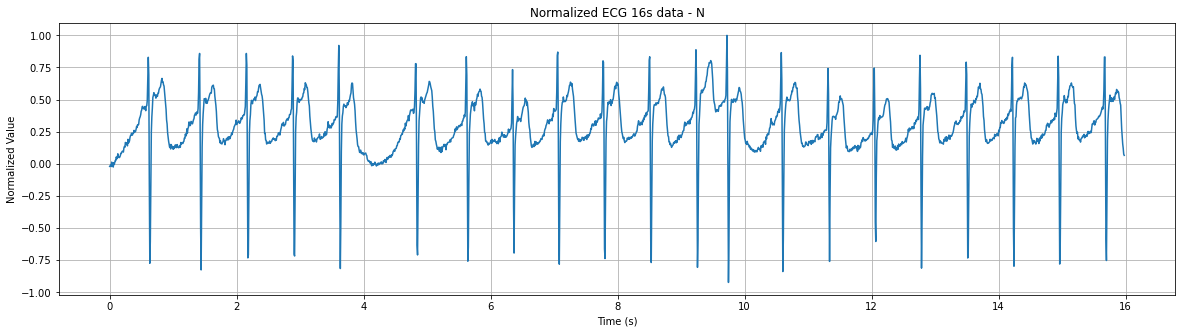

In [30]:
idx = 0
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

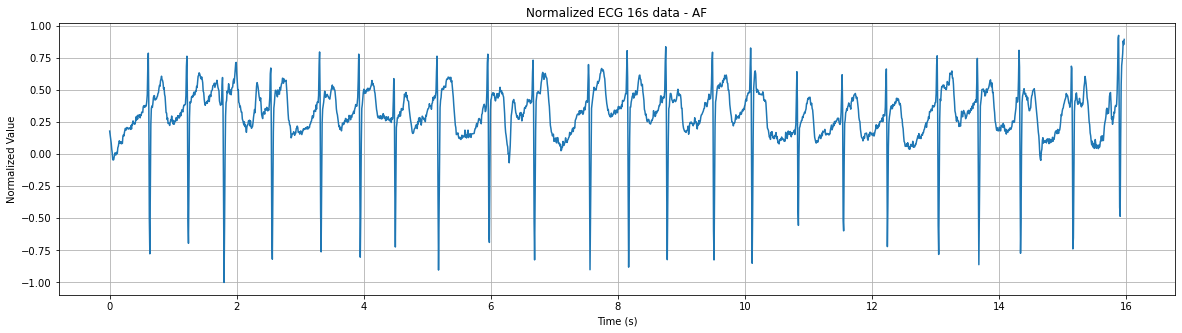

In [31]:
idx = -1
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

- QRS Detection

In [32]:
from ecgdetectors import Detectors

detectors = Detectors(fs)

In [33]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('mV')
    plt.grid(True)
    plt.show()

- Test R peak detector - Christov

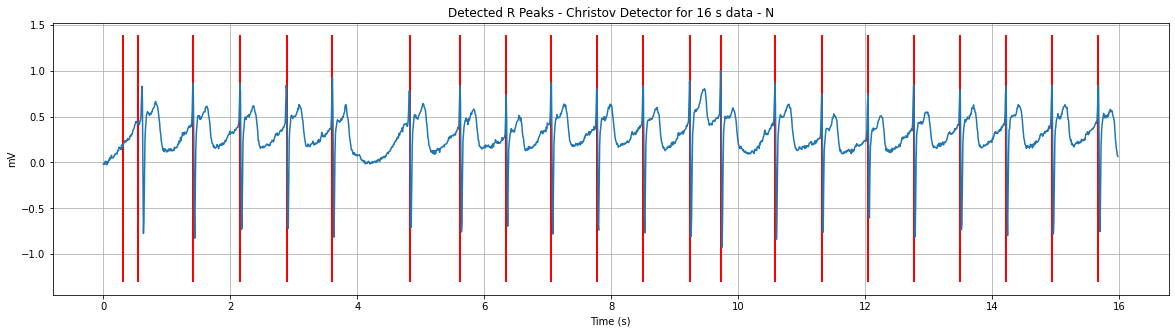

In [34]:
idx = 0

data = np.array(ECG_ALS_Norm[idx])

r_peaks = detectors.christov_detector(data)

plot_r_peaks(r_peaks, data, fs, label="Detected R Peaks - Christov Detector for 16 s data - %s" % ECG_ALS_label[idx])

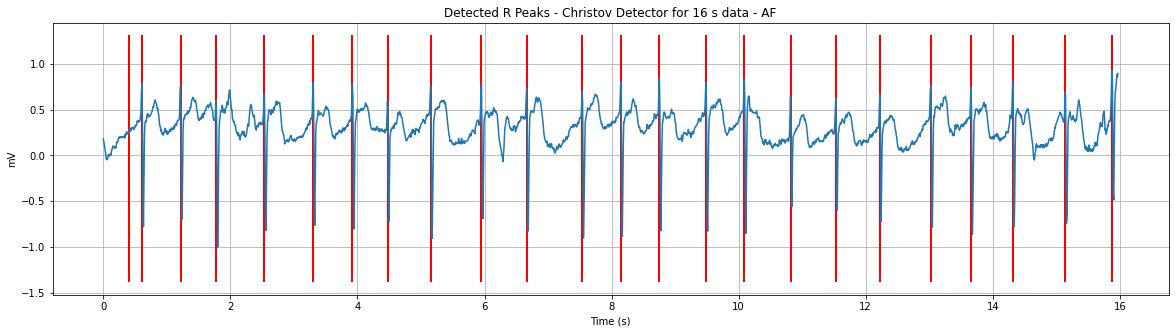

In [35]:
idx = -1

data = np.array(ECG_ALS_Norm[idx])

r_peaks = detectors.christov_detector(data)

plot_r_peaks(r_peaks, data, fs, label="Detected R Peaks - Christov Detector for 16 s data - %s" % ECG_ALS_label[idx])

- Split each 16s to 1.2 x R-R sequence
- Padding the sequence with zero for length 300 point

In [36]:
ECG_split = []
ECG_split_label = []
for i in range(len(ECG_ALS_Norm)) :
    data = np.array(ECG_ALS_Norm[i])
    if len(data) > 0:
        r_peaks = []
        try :
            r_peaks = detectors.christov_detector(data)
        except:
            print("cannot find R peaks in ALS Norm, idx %d" % i)
        RRs = np.diff(r_peaks)
        RRs_med = np.median(RRs)
        if not np.isnan(RRs_med) and RRs_med > 0:
            for rp in r_peaks :
                split = data[:,0][rp : rp + int(RRs_med * 1.2)] 
                pad = np.zeros(150)
                n = len(split) if len(split) <= 150 else 150
                pad[0:n] = split[0:n]
                ECG_split.append(pad)
                ECG_split_label.append(ECG_ALS_label[i])

In [37]:
def plot_1_sample(data, label, fs):
    times = np.arange(data.shape[0]) / fs * 1000 

    label = 'Normal' if label == 'N' else 'Atrial Fibrillation'
    plt.plot(times, data)
    plt.title("Plot 1 Sample (%dHz) : %s Beat" % (fs, label))
    plt.xlabel("Time (ms)")
    plt.ylabel("mV")
    plt.grid(True)
    plt.show()

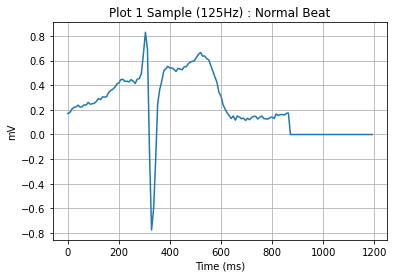

In [38]:
idx = 0
plot_1_sample(ECG_split[idx], ECG_split_label[idx], fs)

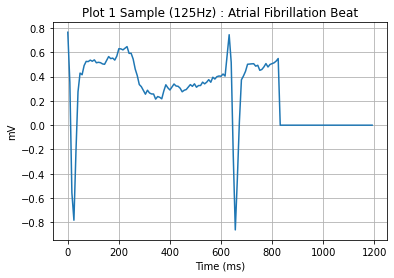

In [39]:
idx = -5
plot_1_sample(ECG_split[idx], ECG_split_label[idx], fs)

In [40]:
data = []
for i in range(len(ECG_split)):
    x = list(ECG_split[i])
    x.append(ECG_split_label[i])
    data.append(x)

In [41]:
ECG = pd.DataFrame(data)

In [42]:
ECG.tail()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
706,0.764489,0.352096,-0.555729,-0.781921,-0.215046,0.274301,0.428491,0.414773,0.490940,0.524733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
707,0.744174,0.516208,-0.248891,-0.861637,-0.444456,0.027550,0.373357,0.404980,0.442892,0.501095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
708,0.807191,0.675835,0.007515,-0.772947,-0.516343,0.045989,0.398684,0.451258,0.468449,0.492110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
709,0.683539,0.667673,0.135474,-0.738994,-0.653296,-0.143754,0.329989,0.412782,0.418140,0.464545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
710,0.923541,0.400614,-0.414918,-0.485292,0.105891,0.536758,0.688927,0.729588,0.784136,0.880450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF


In [43]:
ECG.to_csv("dataset/AFDB_%s_sequence_300_pt.csv" % record, index=False, header=False)